# Transfer Learning

Closely modeled after fast.ai's [NLP course](https://github.com/fastai/course-nlp).

### Settings & Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os.path
from fastai.text import *

### Data Preprocessing

In [24]:
path = "./Replications/Davidson2017/data"

In [25]:
bs = 128  # Batch size

# If files have been saved, load them.
if os.path.exists(path + "/data_lm_export.pkl"):
    
    print("Loading saved data files...\n")
    
    data_lm = load_data(path, 'data_lm_export.pkl', bs=bs)
    data_clas = load_data(path, 'data_clas_export.pkl', bs=bs)
    data_bwd = load_data(path, 'data_lm_export.pkl', bs=bs, backwards=True)
    
else:
    
    print("Files not found. Creating data files...\n")
    
    # Language model data
    data_lm = TextLMDataBunch.from_csv(path, 'labeled_data.csv', text_cols='tweet', bs=bs)
    # Classifier model data
    data_clas = TextClasDataBunch.from_csv(path, 'labeled_data.csv', text_cols='tweet', label_cols='class', 
                                           vocab = data_lm.train_ds.vocab, bs=bs)
    
    # Save files
    data_lm.save('data_lm_export.pkl')
    data_clas.save('data_clas_export.pkl')
    
    # Load backwards data
    data_bwd = load_data(path, 'data_lm_export.pkl', bs=bs, backwards=True)

Files not found. Creating data files...



In [26]:
data_lm.show_batch()

idx,text
0,xxunk xxbos @iam_troyal5 @teflondon4200 @bossman_carl xxmaj mammy push you out and had a white baby like a bitch xxbos xxunk xxmaj do n't you have a trash can ? xxbos xxunk xxmaj yankees like xxmaj florida xxmaj state ; not xxmaj floridians . xxbos xxmaj hating on me ? xxmaj then bitch what 's good ? xxbos xxunk i would n't know cause i do n't fuck with these hoes
1,you and those guys at the park playing bitch volleyball . # xxunk xxbos xxmaj bunch of hurt niggas & & bitches on my xxup ig timeline tonight .. xxmaj muhfuckas lame as hell b xxbos xxup rt @krislisisms : xxmaj today something is dope . xxmaj tomorrow that same thing is trash . xxmaj next month it is irrelevant . xxmaj next year it 's classic . xxbos i
2,: xxmaj since you could n't keep my dick outa your mouth at least keep my name out of it . xxmaj y'all some hoes for real . xxbos xxup rt xxunk : xxmaj had a crush on a bitch with a man i tried to show her that i could treat her better but i never had no luck xxbos xxup rt @dallywaggz12 : “ @justreiatabie : xxmaj charlie
3,"i wo n't say how many bitches i fucked but i might say how many 100s i touched 💲 💲 💲 xxbos @b0ssladyre just ate a xxunk brownie and is seeing random cats xxbos xxmaj tickets hoe http : / / t.co / xxunk xxbos she pooted “ xxunk : xxmaj either xxmaj young xxmaj thug gay , or this bitch pooted https : / / t.co / xxunk ”"
4,hoe that 's your work outfit xxbos xxunk better nig . xxmaj lol but if anything ill flip u the 10 or something . i m tryna get some more cash xxbos xxmaj some of these hoes deserve a kick in their vagina .. xxmaj lucky i ai nt tryna loose my shoe ! xxbos “ xxunk _ : b xxmaj oreo a xxunk thru 🔥 🔥 🔥 xxbos xxup


In [27]:
data_clas.show_batch()

text,target
xxbos xxmaj was finna slit my eyebrows up in the shop but na xxrep 6 h . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n,2
"xxbos xxup rt @sportscenter : xxmaj yankees survive 9th - xxunk scare to beat xxmaj xxunk , 12 - 11 . \n • xxmaj gardner : 4 - 5 , xxup hr , xxup xxunk , 3 r \n • xxmaj teixeira : 1 - 2 , xxup hr , 2 xxup xxunk , 3 r htt …",2
"xxbos xxup rt xxunk : i be like wassup bitch ? ! \n ¯ \ ( ˘o˘ ) / ¯ \n ) ) \n | \ \n | | _ \n "" huh ? nothing "" \n \n that 's what i thought hoe . \n ( ˘o˘ ) \n < ) …",1
"xxbos xxmaj my manager xxunk new brand | xxup pre - xxup order xxup now w / \n ( xxunk ) xxunk - xxunk xxunk -- > xxunk "" xxmaj red xxmaj xxunk "" & & "" xxmaj cherry xxmaj white "" beanies http : / / t.co / xxunk",2
"xxbos xxup rt xxunk : “ @16stanleys : xxmaj ugh he 's mine bitches ! xxmaj he 's mine & & mine only . xxmaj that 's my baby , my man . xxmaj just know & & be aware . xxmaj that 's me ! ” 👏 👏 👏",1


### Fine-Tuning (Forward)

In [42]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=1).to_fp16(clip=0.1)
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


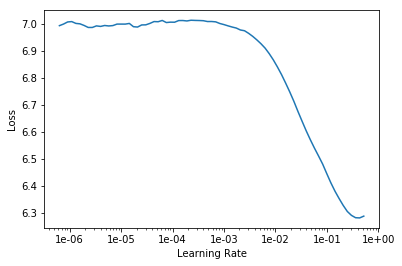

In [43]:
learn_lm.recorder.plot(skip_end=15)

In [44]:
learn_lm.fit_one_cycle(1, 5e-2,  moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.114320,4.335579,0.267634,00:11


In [45]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, slice(1e-4,1e-2), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.425808,4.185560,0.280692,00:14
1,4.285418,4.065583,0.292662,00:14
2,4.119760,4.012702,0.297117,00:14
3,3.943361,3.990196,0.301776,00:14
4,3.813872,3.990281,0.302111,00:14


In [46]:
learn_lm.save_encoder('fwd_enc')

### Fine-Tuning (Backward)

In [47]:
learn_bwd = language_model_learner(data_lm, AWD_LSTM, drop_mult=1).to_fp16(clip=0.1)
learn_bwd.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [48]:
learn_bwd.fit_one_cycle(1, 1e-2,  moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.373314,4.423134,0.256204,00:11


In [49]:
learn_bwd.unfreeze()
learn_bwd.fit_one_cycle(5, slice(1e-4,1e-2), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.610384,4.186933,0.283036,00:14
1,4.393055,4.041828,0.294773,00:14
2,4.168946,3.966893,0.301600,00:14
3,3.970195,3.947033,0.304669,00:14
4,3.818651,3.946035,0.305441,00:14


In [50]:
learn_bwd.save_encoder('bwd_enc')